# 3. Modelling & Evaluation

**Sari Farah**

**BrainStation, Data Science**

**Previous Notebook: 2. EDA**

**Next Notebook: 4. Appendix**

In the previous notebook, we did some initial analysis to explore the relationship between our input and target variables. In this notebook, we will be modelling.

We are trying to predict a classification of goal or no goal. So we want to use classification models.

The evaluation metric used to determine which model performs best is 
- F1 score: F1-score is the harmonic mean of precision and recall. It combines precision and recall into a single number
- ROC/AUC: ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

In this notebook, I want to test the following models.

- Logistic Regression model
- K Nearest Neighbors (KNN model)
- Support Vector Machine (SVM model)
- Random Forest 

In [1]:
#importing the libraries I need 

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve


import joblib

Read in our data:

In [2]:
df = pd.read_csv('/Users/sarifarah/Desktop/Sari_Farah_Capstone_Final/df_modelling_final.csv')

Columns I forgot to drop in the last notebook.

In [3]:
df = df.drop(columns = ['player', 'player_id'])

Player ID is not beneficial to our model and will be read as an ordinal value, so it will not be beneficial to us. As for player, this column is addressed on our next steps.

## onehotencoding

I am onehot encoding the team names below:

In [4]:
#instantiating the onehot encoder 
ohe = OneHotEncoder()

#fit and transform 
h_team_df = pd.DataFrame(df['h_team'])
ohe_h_team = ohe.fit_transform(h_team_df)

ohe_h_team

<227614x135 sparse matrix of type '<class 'numpy.float64'>'
	with 227614 stored elements in Compressed Sparse Row format>

In [5]:
#convert to dense array
ohe_h_team_dense = ohe_h_team.toarray()

h_team_df = pd.DataFrame(ohe_h_team_dense, columns=ohe.categories_[0]).astype('int')

In [6]:
#sanity check and inspection
h_team_df.head()

,AC Milan,Alaves,Amiens,Angers,Arsenal,Aston Villa,Atalanta,Athletic Club,Atletico Madrid,Augsburg,...,Valencia,Verona,VfB Stuttgart,Villarreal,Watford,Werder Bremen,West Bromwich Albion,West Ham,Wolfsburg,Wolverhampton Wanderers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#merging my onehotencoded dataframe to my main dataframe 
df = pd.concat([df, h_team_df], axis=1)

In [8]:
#instantiating the onehot encoder 
ohe = OneHotEncoder()

#fit and transform 
a_team_df = pd.DataFrame(df['a_team'])
ohe_a_team = ohe.fit_transform(a_team_df)

ohe_a_team

<227614x135 sparse matrix of type '<class 'numpy.float64'>'
	with 227614 stored elements in Compressed Sparse Row format>

In [9]:
#convert to dense array
ohe_a_team_dense = ohe_a_team.toarray()

a_team_df = pd.DataFrame(ohe_a_team_dense, columns=ohe.categories_[0]).astype('int')

In [10]:
#sanity check and inspection
a_team_df.head()

,AC Milan,Alaves,Amiens,Angers,Arsenal,Aston Villa,Atalanta,Athletic Club,Atletico Madrid,Augsburg,...,Valencia,Verona,VfB Stuttgart,Villarreal,Watford,Werder Bremen,West Bromwich Albion,West Ham,Wolfsburg,Wolverhampton Wanderers
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We should be onehotencoding in our pipelines below, however this is causing the models to take a very long time to run. I have mentioned that this will be something that is fixed in my next steps, as it causes data leakage. 

In [11]:
#merging my onehotencoded dataframe to my main dataframe 
df = pd.concat([df, a_team_df], axis=1)

Dropping the encoded columns. Also dropping Id as it is irrelevant to our shot data and our models will interpret it as an ordinal category. This will not give us the best results.

In [12]:
#I can drop these columns as they are now onehot econoded
df = df.drop(columns = ['a_team', 'h_team', 'id'])
df.head()

,minute,result,X,Y,h_a,season,match_id,h_goals,a_goals,player_assisted,...,Valencia,Verona,VfB Stuttgart,Villarreal,Watford,Werder Bremen,West Bromwich Albion,West Ham,Wolfsburg,Wolverhampton Wanderers
0,27,0,17,28,1,2015,81,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27,0,10,42,1,2015,81,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,35,0,12,22,1,2015,81,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,35,0,11,36,1,2015,81,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,40,0,15,48,1,2015,81,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df.shape

(227614, 287)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227614 entries, 0 to 227613
Columns: 287 entries, minute to Wolverhampton Wanderers
dtypes: float64(2), int64(285)
memory usage: 498.4 MB


## Logistic Regression

Logistic regression is a supervised learning classification algorithm used to predict the probability of a target variable. The nature of target or dependent variable is dichotomous, which means there would be only two possible classes.

In [15]:
#passing features and target to variables 

#dependent variables 
X = df.drop(columns='result')
y = df['result']

In [16]:
#train test split on our dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [17]:
## FIT ONLY ON TRAIN SET
scaler = StandardScaler()
scaler.fit(X_train) # finds the mean and std of each column


### TRANSFORM TRAIN AND TEST with the SAME SCALER
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) # I shift the test columns using the means from the training set

logit1 = LogisticRegression().fit(X_train, y_train)

In [18]:
print(f'Training accuracy: {logit1.score(X_train,y_train)}')
print(f'Testing accuracy: {logit1.score(X_test,y_test)}')

Training accuracy: 0.8936081409844528
Testing accuracy: 0.8931968455506007


This is a really good score! But is it? Lets dig deeper and take a look at a confusion matrix and classification report to better understand what is happening. 

              precision    recall  f1-score   support

           0       0.90      1.00      0.94     40705
           1       0.44      0.03      0.06      4818

    accuracy                           0.89     45523
   macro avg       0.67      0.51      0.50     45523
weighted avg       0.85      0.89      0.85     45523



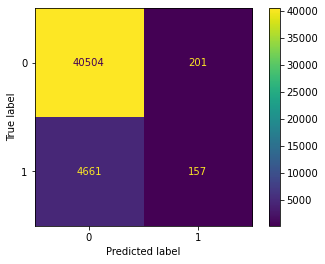

In [19]:
#predictions on test data 
y_pred = logit1.predict(X_test)

#call confusion matrix 
plot_confusion_matrix(logit1, X_test, y_test, cmap='viridis')

print(classification_report(y_test, y_pred))

In [20]:
40506+199+4663+155

45523

In [21]:
print(f'False Positives (Type I error): {(199/45523)*100}%')
print(f'False Negatives (Type II error): {(4663/45523)*100}%')

False Positives (Type I error): 0.4371416646530325%
False Negatives (Type II error): 10.243173780286888%


Precision measures what proportion of a model assigned to positive are actually members of the positive class: The percision for our model is 0.44. This means 44% of all class 1 predictions were actually class 1.

On the other hand, recall measures how many members of the positive class the model correctly identified out of the total positives: The recall for our model is 0.03. This means 3% of 'actual' class 1 observations are predicted correctly.  

False Positives (Type I errors) make up ~ 0.43% of predictions 
False Negatives (Type II errors) make up ~10% of predictions 

Now we can understand why we are truly getting a high accuracy. This is due to the highly imbalanced classes that we have. Essentially, almost 89.4% of or observations lie in the no goal class (0). In other words, if our model were to predict everything as a 0 we would still get the same score. 

In [22]:
y.value_counts(normalize=True)

0    0.894159
1    0.105841
Name: result, dtype: float64

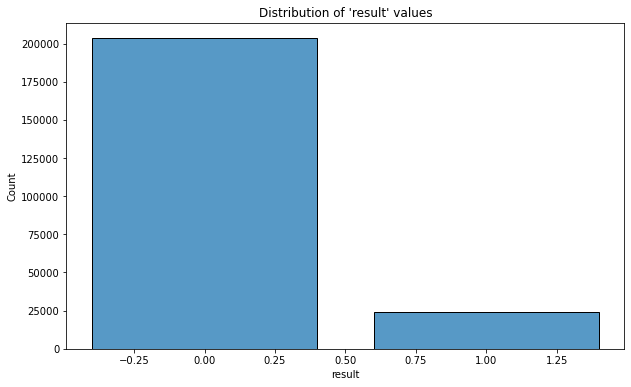

In [55]:
plt.figure(figsize=(10,6))
sns.histplot(df['result'], discrete=True, shrink=0.8)
plt.title("Distribution of 'result' values")
plt.show()

As we can see we have a very imbalanced dataset that gave us a good score, however when we dug deeper we saw its underlying problems. One approach we could take is upsampling our data. This entails us resampling the observations that belong to the underrepresented class so that our training data consists of equal proportions of each class. Our logistic regression model above didnt really do much. Essentially, it more or less predicted everything as a non goal(0) and gave us a 89% prediction accuracy, but this was useless as we see that this is equivalent to our class imbalabce value.


### Upsampling

Upsampling is a procedure where synthetically generated data points (corresponding to minority class) are injected into the dataset. After this process, the counts of both labels are almost the same. This equalization procedure prevents the model from inclining towards the majority class.

In [23]:
# Upsample
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    n_samples=X_train[y_train == 0].shape[0], 
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train = np.vstack((X_train[y_train == 0], X_upsampled))
y_train = np.hstack((y_train[y_train == 0], y_upsampled))

Number of class 1 examples before: 19273
Number of class 1 examples after: 162818


In [24]:
## FIT ONLY ON TRAIN SET
scaler = StandardScaler()
scaler.fit(X_train) # finds the mean and std of each column


### TRANSFORM TRAIN AND TEST with the SAME SCALER
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) # I shift the test columns using the means from the training set

In [25]:
#fitting the model
logit1 = LogisticRegression().fit(X_train, y_train)

In [26]:
print(f'Training accuracy: {logit1.score(X_train,y_train)}')
print(f'Testing accuracy: {logit1.score(X_test,y_test)}')

Training accuracy: 0.7158606542274196
Testing accuracy: 0.6922215143993147


As we can see our scores have changed severley. Our scores for training and testing have dropped immensely. As we did for our last logistic regression model, we will check our our precision and recall to understand the nitty gritty of our model. 

### Confusion Matrix

A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model.

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     40705
           1       0.22      0.72      0.33      4818

    accuracy                           0.69     45523
   macro avg       0.59      0.71      0.57     45523
weighted avg       0.88      0.69      0.75     45523



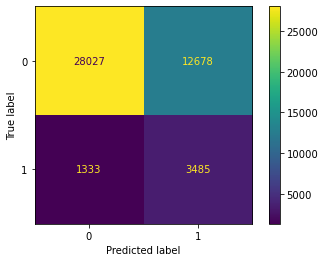

In [27]:
#predictions on test data 
y_pred = logit1.predict(X_test)

#call confusion matrix 
plot_confusion_matrix(logit1, X_test, y_test, cmap='viridis')

print(classification_report(y_test, y_pred))

In [56]:
print(f'False Positives (Type I error): {(12678/45523)*100}%')
print(f'False Negatives (Type II error): {(1333/45523)*100}%')

False Positives (Type I error): 27.849658414427868%
False Negatives (Type II error): 2.928190145640665%


The percision for our model is 0.22. This means 22% of all class 1 predictions were actually class 1. As we can see our percision has dropped by half. 

On the other hand, The recall for our model is 0.72. This means 72% of 'actual' class 1 observations are predicted correctly.  

By definition, F1-score is the harmonic mean of precision and recall. It combines precision and recall into a single number. The F1-score takes both precision and recall into account, which also means it accounts for both FPs and FNs. Due to my highly imbalanced dataset, the best model metric to evaluate is the F1 score. 

We have a significantly better F1 score as well, it jumped from 0.06 to 0.33 in our newer model.

- False Positives (Type I errors) make up ~ 27% of predictions 
- False Negatives (Type II errors) make up ~ 3% of predictions 

Now we can understand why the accuracy significantly dropped. 

### ROC Curve 

An ROC curve is a performance measurement for classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

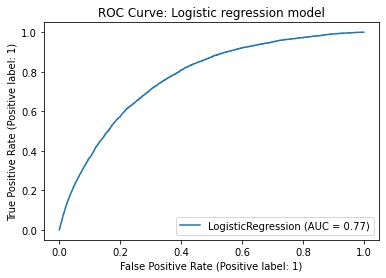

In [61]:
plot_roc_curve(logit1, X_test, y_test)
plt.title('ROC Curve: Logistic regression model')
plt.show()

Each point on the curve represents a tradeoff between true and false positive rates. Since we are not assessing for a life threatening disease or a a faulty mechanical issue occuring we are able to allow a higher amount of false positives. Furthermore with AUC value we are protected from the class imbalance that we have in our data. The shape of our roc curves tells us that has a relatively good ability in distinguishing our two classes.

In [69]:
#these are the parameters we can tune in pursuit of the best model
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [29]:
#instantiate model features 
estimators = [('scaler',StandardScaler()), 
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

#define model feature parameters to be iterated over 
params = [
            {
            'model': [LogisticRegression(random_state=42, max_iter=1000)],
            'scaler': [StandardScaler(), MinMaxScaler()],
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__solver': ['lbfgs', 'liblinear']
            }
]

#consolidate all iterations into one loop
grid_search_logit = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

#fit model specifications 
fitted_search_logit = grid_search_logit.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=0.01, model__solver=lbfgs, scaler=StandardScaler(); total time=   4.8s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=0.01, model__solver=lbfgs, scaler=StandardScaler(); total time=   4.3s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=0.01, model__solver=lbfgs, scaler=StandardScaler(); total time=   5.6s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=0.01, model__solver=lbfgs, scaler=StandardScaler(); total time=   4.0s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=0.01, model__solver=lbfgs, scaler=StandardScaler(); total time=   3.9s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=0.01, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   9.2s
[CV] END model=LogisticRegression(max_iter=1000, random_st

[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   2.9s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   2.9s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   2.8s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   2.9s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=10, model__solver=lbfgs, scaler=StandardScaler(); total time=   4.0s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=10, model__solver=lbfgs, scaler=StandardScaler(); total time=   3.8s
[CV] END model=LogisticRegression(max_iter=1000, random_state=42), model__C=10, model__solver=lbfgs, scaler=StandardScaler(); 

In [30]:
#saving our model as a pkl file as it takes extensive time to run
joblib.dump(fitted_search_logit, "fitted_search_logit.pkl")

['fitted_search_logit.pkl']

In [31]:
#checking it loads
fitted_search_logit = joblib.load("fitted_search_logit.pkl") 

In [32]:
#outputs the best model from the above gridsearchCV
fitted_search_logit.best_params_

{'model': LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear'),
 'model__C': 1,
 'model__solver': 'liblinear',
 'scaler': MinMaxScaler()}

In [33]:
#instantiate model with the optimized hyperparameters 
logit_optimal = fitted_search_logit.best_params_['model']

#fit model to original train data 
logit_optimal.fit(X_train, y_train)

#evaluate model performance 
logit_optimal_train_acc = logit_optimal.score(X_train, y_train)
logit_optimal_test_acc = logit_optimal.score(X_test, y_test)

print(f'Optimized logistic regression model:')
print(f'Train accuracy: {100*(logit_optimal_train_acc)}%')
print(f'Test accuracy: {100*(logit_optimal_test_acc)}%')

Optimized logistic regression model:
Train accuracy: 71.58330160056013%
Test accuracy: 69.22434813171364%


We can see that the score in our optimized logistic regression is almost identical to the baseline logistic regression we modelled above.

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     40705
           1       0.22      0.72      0.33      4818

    accuracy                           0.69     45523
   macro avg       0.59      0.71      0.57     45523
weighted avg       0.88      0.69      0.75     45523



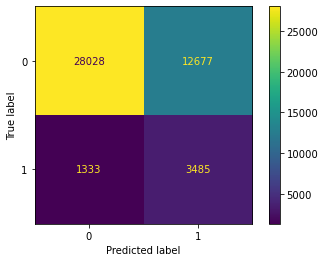

In [59]:
#predictions on test data 
y_pred = logit_optimal.predict(X_test)

#call confusion matrix 
plot_confusion_matrix(logit_optimal, X_test, y_test, cmap='viridis')

print(classification_report(y_test, y_pred))

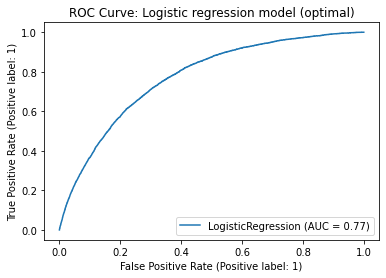

In [70]:
#plotting the roc curve with AUC value 
plot_roc_curve(logit_optimal, X_test, y_test)
plt.title('ROC Curve: Logistic regression model (optimal)')
plt.show()

Gives us identical values from the above logistic regression

## KNN

KNN is a model that classifies data points based on the points that are most similar to it distance wise. It uses test data to make an “educated guess” on what an unclassified point should be classified as. 

In [34]:
#Our data is already scaled 

#Fit the default KNN model
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

print("Using the default number of neighbors:", KNN_model.n_neighbors)
print("Train Accuracy:", KNN_model.score(X_train, y_train))
print("Test Accuracy:", KNN_model.score(X_test, y_test))

Using the default number of neighbors: 5
Train Accuracy: 0.9077620410519721
Test Accuracy: 0.7042813522834611


In [35]:
joblib.dump(KNN_model, "KNN_model.pkl")

['KNN_model.pkl']

In [36]:
KNN_model = joblib.load("KNN_model.pkl")

We see some major improvements in the training data while using the KNN model. 
Our best logistic regression training score from our optimized logistic regression was 71.58%. When using our base KNN it was 90.74%. However the testing data has only slightly improved from 69.22% to 70.35%. 

              precision    recall  f1-score   support

           0       0.91      0.74      0.82     40705
           1       0.15      0.37      0.21      4818

    accuracy                           0.70     45523
   macro avg       0.53      0.56      0.51     45523
weighted avg       0.83      0.70      0.75     45523



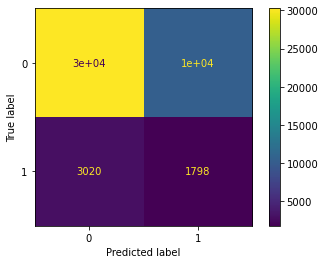

In [57]:
#predictions on test data 
y_pred = KNN_model.predict(X_test)

#call confusion matrix 
plot_confusion_matrix(KNN_model, X_test, y_test, cmap='viridis')

print(classification_report(y_test, y_pred))

We can see here that our model has a percision of 0.15, this decreased from our optimal logistic regression model.Pur recall has also decreased from 0.72 to 0.37. Even thought our model gave us slightly better results our perision and recall values have decreased. Since our percision and recall have both dropped it is expected to see a drop in the F1 score, as we can see it has dropped from 0.33 to 0.21. 

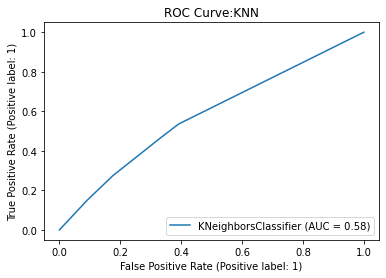

In [62]:
plot_roc_curve(KNN_model, X_test, y_test)
plt.title('ROC Curve:KNN')
plt.show()

We can see a decrease in our Area under the curve (AUC) score from 0.77 to 0.58. This was expected after inspecting our results in the confusion matrix. Also we can see that the shape of our ROC curve has changed. Our Roc curve in our logistic regression model was more concave shaped, here we have more of a linear shape. This is tells us that the classifier is not able to distinguish between Positive and Negative class points very well. 
So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes.

In [68]:
#these are the parameters we can tune in pursuit of the best model
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [37]:
#instantiate model features 
estimators = [('scaler',StandardScaler()), 
              ('model', KNeighborsClassifier())]

pipe = Pipeline(estimators)


#define model feature parameters to be iterated over 
#I could have used different scalers (such as MinMaxScaler), I could have added more neighbours 
#I could have added more 'model__weights' such as 'distance', and 'model__metric' such as 'manhattan' and 'minkowski'
# we can use the "KNeighborsClassifier().get_params().keys()" to see what other parameters could be used 
#I wont run 5 for n_neighbors as the above basic KNN model gives me that result, so i will try 10 and 15 n_neighbours 
#to save time, due to time constraints 
params = [
            {
            'model': [KNeighborsClassifier()],
            'scaler': [StandardScaler()],
            'model__n_neighbors': [10, 15],
            'model__weights' : ['uniform'],
            'model__metric': ['euclidean'] 
            }
]

#consolidate all iterations into one loop
grid_search_knn = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

#fit model specifications 
fitted_search_knn = grid_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END model=KNeighborsClassifier(), model__metric=euclidean, model__n_neighbors=10, model__weights=uniform, scaler=StandardScaler(); total time= 6.7min
[CV] END model=KNeighborsClassifier(), model__metric=euclidean, model__n_neighbors=10, model__weights=uniform, scaler=StandardScaler(); total time= 6.3min
[CV] END model=KNeighborsClassifier(), model__metric=euclidean, model__n_neighbors=10, model__weights=uniform, scaler=StandardScaler(); total time= 6.2min
[CV] END model=KNeighborsClassifier(), model__metric=euclidean, model__n_neighbors=10, model__weights=uniform, scaler=StandardScaler(); total time= 7.4min
[CV] END model=KNeighborsClassifier(), model__metric=euclidean, model__n_neighbors=10, model__weights=uniform, scaler=StandardScaler(); total time= 5.3min
[CV] END model=KNeighborsClassifier(), model__metric=euclidean, model__n_neighbors=15, model__weights=uniform, scaler=StandardScaler(); total time= 7.9min
[CV] END m

In [38]:
joblib.dump(fitted_search_knn, "fitted_search_knn.pkl")

['fitted_search_knn.pkl']

In [39]:
fitted_search_knn = joblib.load("fitted_search_knn.pkl") 

In [40]:
fitted_search_knn.best_params_

{'model': KNeighborsClassifier(metric='euclidean', n_neighbors=10),
 'model__metric': 'euclidean',
 'model__n_neighbors': 10,
 'model__weights': 'uniform',
 'scaler': StandardScaler()}

In [41]:
#instantiate model with the optimized hyperparameters 
knn_optimal = fitted_search_knn.best_params_['model']

#fit model to original train data 
knn_optimal.fit(X_train, y_train)

#evaluate model performance 
knn_optimal_train_acc = knn_optimal.score(X_train, y_train)
knn_optimal_test_acc = knn_optimal.score(X_test, y_test)

print(f'Optimized KNN model:')
print(f'Train accuracy: {100*(knn_optimal_train_acc)}%')
print(f'Test accuracy: {100*(knn_optimal_test_acc)}%')

Optimized KNN model:
Train accuracy: 83.32432532029628%
Test accuracy: 63.05384091558114%


We got an decline in our results from our base KNN model. Our training accuracy and test accuracy went down by 7% from our base knn model. We should investigate this a bit more to see what really happened here. 

              precision    recall  f1-score   support

           0       0.91      0.65      0.76     40705
           1       0.14      0.48      0.22      4818

    accuracy                           0.63     45523
   macro avg       0.53      0.57      0.49     45523
weighted avg       0.83      0.63      0.70     45523



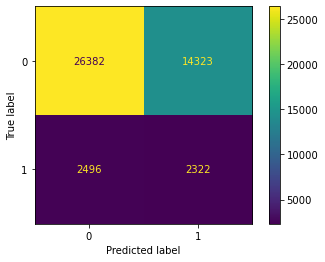

In [64]:
#predictions on test data 
y_pred = knn_optimal.predict(X_test)

#call confusion matrix 
plot_confusion_matrix(knn_optimal, X_test, y_test, cmap='viridis')

print(classification_report(y_test, y_pred))

As we can see our precision score has slightly decreased from 0.15 to 0.15 from our last knn model but our recall has increased from 0.37 to 0.48. Our F1 score has slightly gone up from 0.21 to 0.22. However the F1 score is still lower than that of our logistic regression. For the purposes of this project we will use the f1 score to measure our best model. 

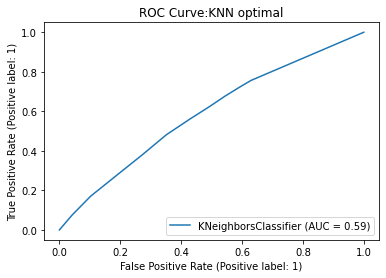

In [65]:
plot_roc_curve(knn_optimal, X_test, y_test)
plt.title('ROC Curve:KNN optimal')
plt.show()

We can see that the ROC cure for our optimal knn model has more or less the same shape as our basic knn model which looks linear. The AUC has increased minimally bu 0.01 from 0.58 to 0.59. compared to out logistic regression model this is quite low as the AUC in our logistic regression model is 0.77.

## SVM

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data are transformed in such a way that the separator could be drawn as a hyperplane.

In [42]:
#svc = svm.SVC()

#instantiate model features 
#estimators = [('scaler',StandardScaler()), ('model',SVC())]

#instantiate the pipeline 
#pipe = Pipeline(estimators)

#define model feature parameters to be iterated over 
#params = [
          #{'model': [SVC()],
           #'scaler': [MinMaxScaler()],
           #'model__C': [5, 10],
           #'model__kernel': ('linear', 'rbf')}
#]

#consolidate all iterations into one loop
#grid_search_svm = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

#fit model specifications 
#fitted_search = grid_search_svm.fit(X_train, y_train)

In [43]:
#joblib.dump(fitted_search_svm, "fitted_search_svm.pkl")

In [44]:
#fitted_search_svm = joblib.load("fitted_search_svm.pkl") 

In [45]:
#fitted_search_svm.best_params_

In [46]:
#instantiate model with the optimized hyperparameters 
#svm_optimal = fitted_search_svm.best_params_['model']

#fit model to original train data 
#svm_optimal.fit(X_train, y_train)

#evaluate model performance 
#svm_optimal_train_acc = svm_optimal.score(X_train, y_train)
#svm_optimal_test_acc = svm_optimal.score(X_test, y_test)

#print(f'Optimized logistic regression model:')
#print(f'Train accuracy: {100*(svm_optimal_train_acc)}%')
#print(f'Test accuracy: {100*(svm_optimal_test_acc)}%')

**I wanted to run this SVM model but it took too long to compute. Due to time constraints I could not wait for the model to finish running. I stopped running it after 8 hours. This will be included in my next steps.**

## Random Forest

Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.

In [47]:
#these are the parameters we can tune in pursuit of the best model
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [48]:
random_forest = RandomForestClassifier(n_estimators=50)

#instantiate model features 
estimators = [('model',RandomForestClassifier())]

#instantiate the pipeline 
pipe = Pipeline(estimators)

#define model feature parameters to be iterated over 
params = [
          {'model': [RandomForestClassifier()],
           'model__n_estimators': [5, 10, 15, 20],
           'model__max_depth': [1, 5, 10]}
]

#consolidate all iterations into one loop
grid_search_random_forest = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2)

#fit model specifications 
fitted_search_random_forest = grid_search_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=5; total time=   1.1s
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=5; total time=   1.0s
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=5; total time=   1.0s
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=5; total time=   1.1s
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=5; total time=   1.0s
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=10; total time=   1.6s
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=10; total time=   1.5s
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=10; total time=   1.4s
[CV] END model=RandomForestClassifier(), model__max_depth=1, model__n_estimators=10; total time=   1.4s
[CV] END

In [49]:
joblib.dump(fitted_search_random_forest, "fitted_search_random_forest.pkl")

['fitted_search_random_forest.pkl']

In [50]:
fitted_search_random_forest = joblib.load("fitted_search_random_forest.pkl") 

In [51]:
fitted_search_random_forest.best_params_

{'model': RandomForestClassifier(max_depth=10, n_estimators=20),
 'model__max_depth': 10,
 'model__n_estimators': 20}

In [52]:
#instantiate model with the optimized hyperparameters 
random_forest_optimal = fitted_search_random_forest.best_params_['model']

#fit model to original train data 
random_forest_optimal.fit(X_train, y_train)

#evaluate model performance 
random_forest_optimal_train_acc = random_forest_optimal.score(X_train, y_train)
random_forest_optimal_test_acc = random_forest_optimal.score(X_test, y_test)

print(f'Optimized Random Forest model:')
print(f'Train accuracy: {100*(random_forest_optimal_train_acc)}%')
print(f'Test accuracy: {100*(random_forest_optimal_test_acc)}%')

Optimized Random Forest model:
Train accuracy: 74.17515262440271%
Test accuracy: 70.49623267359357%


We can see here that our training set has the lowest accuracy out of all our models, however the accuracy for our test set is the highest so far.

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     40705
           1       0.23      0.75      0.35      4818

    accuracy                           0.70     45523
   macro avg       0.59      0.73      0.58     45523
weighted avg       0.88      0.70      0.76     45523



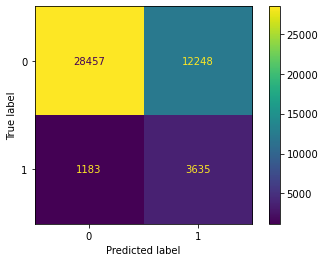

In [66]:
#predictions on test data 
y_pred = random_forest_optimal.predict(X_test)

#call confusion matrix 
plot_confusion_matrix(random_forest_optimal, X_test, y_test, cmap='viridis')

print(classification_report(y_test, y_pred))

Out of all our models we have the highest precision and recall scores in this model. As previously stated the F1 metric is the one that matters most for the purpose of this project due to the high class imbalance. We also witness the highest F1 score here with 0.35. 

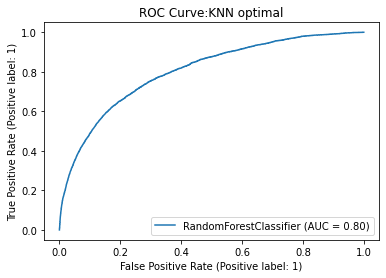

In [67]:
plot_roc_curve(random_forest_optimal, X_test, y_test)
plt.title('ROC Curve:KNN optimal')
plt.show()

We can see here that our ROC curve looks similar to that of our upsampled logistic regression model. However our AUC value is slighlty higher at 0.8. 

Overall, our random forest model is the best model as it has the highest test accuracy in addition to having the highest F1 score and AUC values. 

In addition to the above, this was the model that took the least time to compute, leading me to believe it is computationally the lest expensive model to run. 

## Conclusion

In this notebook we used GridSearchCV to optimize the hyperparameters of different models which helped determine which of these models performed the best. GridSearchCV uses cross validation scores to determine which model performs the best. The best model we found was the random forest classifier, it has an F1 score of 0.35, and AUC of 0.8 and a test accuracy of 70.49%. 

### Findings

Our main findings is that the shots that result in the highest probability of scoring are the ones taken from the shortest distance and widest angle. However, the amount of shots taken from favourable locations and angles also do result in misses quite often. For this reason, when modelling, we werent able to get the results that we'd hoped for due to the fact that shots that end up being scored or missed often do have very similar characteristics. We were able to see this in our modelling by getting alot of false positives and false negatives.

Furthermore, as we saw in our heatmap plots in EDA notebook, the most densely populated areas for shots on the pitch are the areas infront of goal. When we filtered for goals only, we saw a massive decrease in the heatmaps intensity, however the observations were still in the same location, which leads us to further believe the fact that shots that were missed and scored have very similar characteristics even though the large majority end up being a miss. 

## Next steps: 

Due to time constraints there were some ideas I had in mind that I could not accomplish, If I had more time I would: 
- Find statistical data for each player, such as current goals ratio, conversion ratio, and so forth to incorporate into my analysis, The reason for this would be that the model would be able to evaluate which players are better finishers and that would increase the likelihood of their shot.
- Add more features due to the fact that different shots from the same ditance and angle could be entirely different if there is a defender in front of the shooter versus no defender infront of the shooter. If I had defenders positions at the time of the shot, that could better classify if the shot was successful or not.
- I would incorporate statistical measures for the teams such as current average goals per game, or current average clean sheets per game. I would be able to incorporate that into my analysis to assess whether a team is likely to score and be scored on, which would give the machine learning models more information on the outcome of the shot. 
- Also, given time constraints, my model runtime was too long to be able to onehotencode the teams while using gridsearchcv, which introduced some data leakage. I would make sure to avoid this as data leakage is cancerous to modelling. 
- I would use pyspark on AWS for modelling my machine learning techniques as it would save me lots of time and give me the ability to pass larger amounts of hyperparamaters for optimal tuning. 
- I would train-test-split my data using techniques other than upsampling to see what yields the best results. This would include downsampling and SMOTE. 
- I would use gridsearchCV on many more hyperparameters.
